In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [4]:
torch.backends.cudnn.benchmark=True

## Setup

In [282]:
PATH = Path('data/pascal-voc')

In [283]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())

In [284]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [285]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [286]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [287]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

## Multi label

In this portion we'll be doing multi-label classification of the images

In [288]:
MC_CSV = PATH/'tmp/mc.csv' #path to multi class label file

In [289]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

Creating labels file for multi-label object detection

In [290]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [291]:
df = pd.DataFrame(
    {
        'fn': [trn_fns[o] for o in trn_ids],
        'clas': mcs
    }, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [292]:
f_model = resnet34  #model
sz = 224  #size passed to the network
bs = 64  #batch-size

In [293]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO) #transforms
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms) #model data

In [294]:
learn = ConvLearner.pretrained(
    f_model, md)  #create a learner which is equivalent to the training loop
learn.opt_fn = optim.Adam  #defining the optimizer

In [19]:
lrf = learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.409402   10.94741   0.6038    



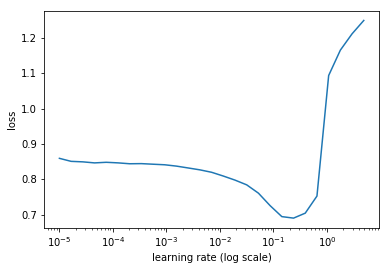

In [20]:
learn.sched.plot(0)

In [21]:
lr = 2e-2

In [22]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.329738   0.138634   0.9566    
    1      0.174397   0.084416   0.9725                    
    2      0.117535   0.076799   0.9737                    



[array([0.0768]), 0.9736999897956848]

In [91]:
lrs = np.array([lr / 100, lr / 10, lr])

In [92]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:15<00:03,  1.65it/s, loss=0.289] 

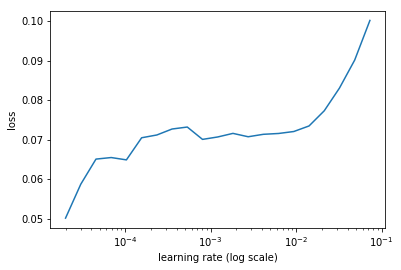

In [93]:
learn.lr_find(lrs / 1000)
learn.sched.plot(0)

In [94]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                     


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>                   
    0      0.070766   0.077205   0.9742    
    1      0.053343   0.083032   0.9733                     
    2      0.038382   0.082619   0.9729                     
    3      0.027511   0.077383   0.9754                     
    4      0.019853   0.077813   0.9751                     



[array([0.07781]), 0.9750999989509582]

In [95]:
learn.save('mclas')

In [96]:
learn.load('mclas')

In [97]:
y = learn.predict()
x, _ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


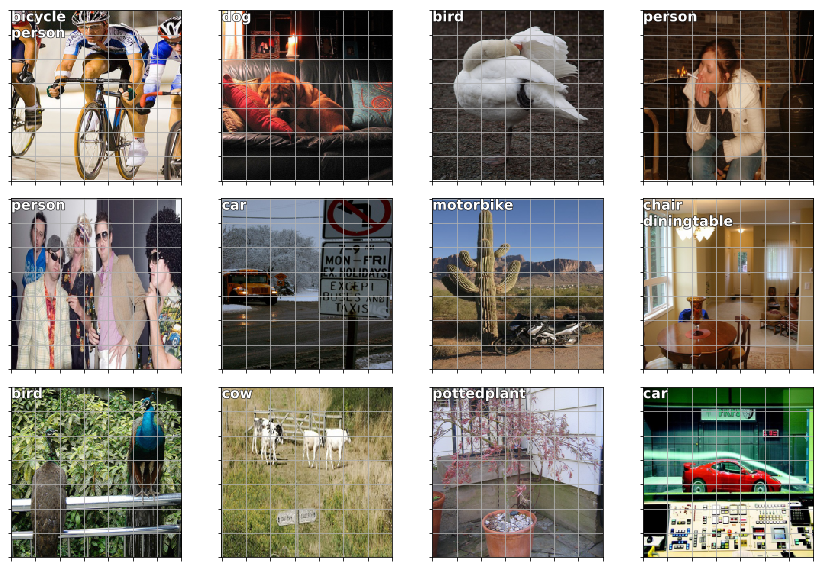

In [98]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i] > 0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()

## Bbox per cell

### Set up data

In [296]:
CLAS_CSV = PATH / 'tmp/clas.csv'
MBB_CSV = PATH / 'tmp/mbb.csv'

f_model = resnet34  #model
sz = 224  #size of image going into the network
bs = 64  #batch size

In [297]:
trn_ids[:2]  #sample training image ids

[12, 17]

In [298]:
trn_anno[12]  #annotation for image_id = 12

[(array([ 96, 155, 269, 350]), 7)]

In [299]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]

In [300]:
mc[:2]  #sample categories

[['car'], ['person', 'horse']]

In [301]:
id2cat = list(cats.values())

In [302]:
id2cat  #all the distinct classes: 21

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [303]:
cat2id = {v: k for k, v in enumerate(id2cat)}

In [304]:
cat2id  #category_name to category_id

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [305]:
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
mcs  #array of category ids for each image

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [306]:
len(trn_fns) #2501 training images

2501

In [307]:
val_idxs = get_cv_idxs(len(trn_fns))  #20% of data in validation (indices)

In [308]:
((val_mcs, trn_mcs), ) = split_by_idx(
    val_idxs, mcs)  # splitting data into train and validation

In [309]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids] #bounding box for each image

In [310]:
mbb[:2]

[array([ 96, 155, 269, 350]), array([ 61, 184, 198, 278,  77,  89, 335, 402])]

In [311]:
mbbs = [' '.join(str(p) for p in o) for o in mbb] #concatenating bbox as string

In [312]:
mbbs[:2]

['96 155 269 350', '61 184 198 278 77 89 335 402']

In [313]:
#saving bbox labels
df = pd.DataFrame(
    {
        'fn': [trn_fns[o] for o in trn_ids],
        'bbox': mbbs
    },
    columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)

In [314]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402
2,000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [315]:
#defining transforms for augmenation and model data
aug_tfms = [
    RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
    RandomFlip(tfm_y=TfmType.COORD)
]
tfms = tfms_from_model(
    f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(
    PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [316]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

#need to understand this part


def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N - 1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba


num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [317]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    '''
    plotting ground truth boxes and class label
    ax: refer to individual plot or axis on the figure
    im: image matrix
    bbox: bounding box for the image
    clas: class label for that image
    prs: ?
    thresh: ?
    '''
    bb = [bb_hw(o) for o in bbox.reshape(-1, 4)] #reshaping the bbox 1-D array and splitting in factor of 4
    if prs is None: prs = [None] * len(bb) #don't know
    if clas is None: clas = [None] * len(bb) #if class is present then 
    ax = show_img(im, ax=ax)
    for i, (b, c, pr) in enumerate(zip(bb, clas, prs)):
        if ((b[2] > 0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i % num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c == len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i % num_colr])

In [318]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2 
        self.sz = ds.sz #input size = 224 

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i] #x is the image matrix, y
        return (x, (y, self.y2[i])) #(image matrix, ((bbox, category_id), category_id))

In [319]:
tmp_x, tmp_y = next(iter(md.trn_ds))

In [320]:
tmp_x #actual image

array([[[-0.81757, -0.85322, -0.86272, ..., -0.97125, -1.02124, -1.07566],
        [-0.83018, -0.85647, -0.87261, ..., -0.92274, -0.97492, -1.00906],
        [-0.82275, -0.81431, -0.81591, ..., -0.90488, -0.89187, -0.9007 ],
        ...,
        [-0.69241, -0.68727, -0.64825, ..., -0.55026, -0.60778, -0.62333],
        [-0.64579, -0.63604, -0.60193, ..., -0.59701, -0.58496, -0.58662],
        [-0.59395, -0.59607, -0.59208, ..., -0.62408, -0.62973, -0.64138]],

       [[-0.70635, -0.7428 , -0.75251, ..., -0.89368, -0.895  , -0.93668],
        [-0.71925, -0.74613, -0.76263, ..., -0.84409, -0.84764, -0.86859],
        [-0.71165, -0.70303, -0.70466, ..., -0.81494, -0.76986, -0.76819],
        ...,
        [-0.59516, -0.5934 , -0.56515, ..., -0.49922, -0.50564, -0.50778],
        [-0.5475 , -0.54102, -0.51942, ..., -0.50155, -0.47324, -0.47025],
        [-0.4945 , -0.50016, -0.50824, ..., -0.51997, -0.51156, -0.52624]],

       [[-0.51436, -0.52876, -0.52694, ..., -0.65245, -0.67854, -0.726

In [321]:
tmp_y #bounding box and category id

array([ 65.,  70., 177., 155.], dtype=float32)

In [322]:
trn_mcs #category id

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([16]),
       array([17,  8, 14, 14, 14]), array([6])], dtype=object)

In [323]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)  #defining training dataset

In [324]:
tmp_x, tmp_y = next(iter(trn_ds2))

In [325]:
tmp_x

array([[[-0.97677, -1.0083 , -0.991  , ..., -1.03766, -1.05221, -1.04772],
        [-0.96642, -0.98239, -0.97503, ..., -1.0513 , -1.06908, -1.06236],
        [-1.04337, -1.04454, -1.03836, ..., -1.09012, -1.09094, -1.10289],
        ...,
        [-0.75048, -0.7196 , -0.73682, ..., -0.71028, -0.74306, -0.70024],
        [-0.79437, -0.75764, -0.75585, ..., -0.73396, -0.76079, -0.71792],
        [-0.79758, -0.76311, -0.73467, ..., -0.76541, -0.75593, -0.75992]],

       [[-0.86911, -0.90134, -0.88366, ..., -0.93135, -0.94846, -0.95028],
        [-0.85853, -0.87485, -0.86733, ..., -0.9453 , -0.97095, -0.97205],
        [-0.93671, -0.93608, -0.93125, ..., -0.98499, -1.00292, -1.01726],
        ...,
        [-0.66921, -0.63694, -0.64322, ..., -0.61375, -0.64668, -0.60411],
        [-0.71371, -0.67248, -0.66146, ..., -0.63277, -0.65731, -0.61971],
        [-0.71697, -0.67662, -0.6393 , ..., -0.65671, -0.64334, -0.65478]],

       [[-0.67764, -0.71033, -0.6923 , ..., -0.73811, -0.75099, -0.746

In [326]:
tmp_y

(array([ 64.,  69., 178., 155.], dtype=float32), array([6]))

In [327]:
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)  #creating validation dataset

md.trn_dl.dataset = trn_ds2  #changing the default training dataset

md.val_dl.dataset = val_ds2  #changing the default validation dataset

In [328]:
tmp_x,tmp_y = next(iter(md.val_dl))

In [329]:
tmp_y[0][0] #64: batch size and 56 is as maximum number of objects in an image is 14 for this batch


   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
  91
  47
 223
 169
   0
  49
 205
 180
   9
 169
 217
 222
[torch.cuda.FloatTensor of size 56 (GPU 0)]

In [330]:
tmp_y[1] #maximum number of objects in an image is 14



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     1    14
    0     0     0     0     0     0     0     0     0     0     0     0    11
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    14    14    14    14    14     4
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     8    10
    0     0     0     0     0     0     0     0     0     0     0     0     2
    0     0     0     0     0     0     0     0     0     0     0     9     9
    0     0     0     0     0     0     0     0     0     0     0     0    15
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    

In [331]:
x, y = to_np(next(iter(md.val_dl)))  #to_np converts to numpy and move to cpu

x = md.val_ds.ds.denorm(
    x)  #denormalize based on the normalization used for imagenet

x, y = to_np(next(iter(md.trn_dl)))

x = md.trn_ds.ds.denorm(x)

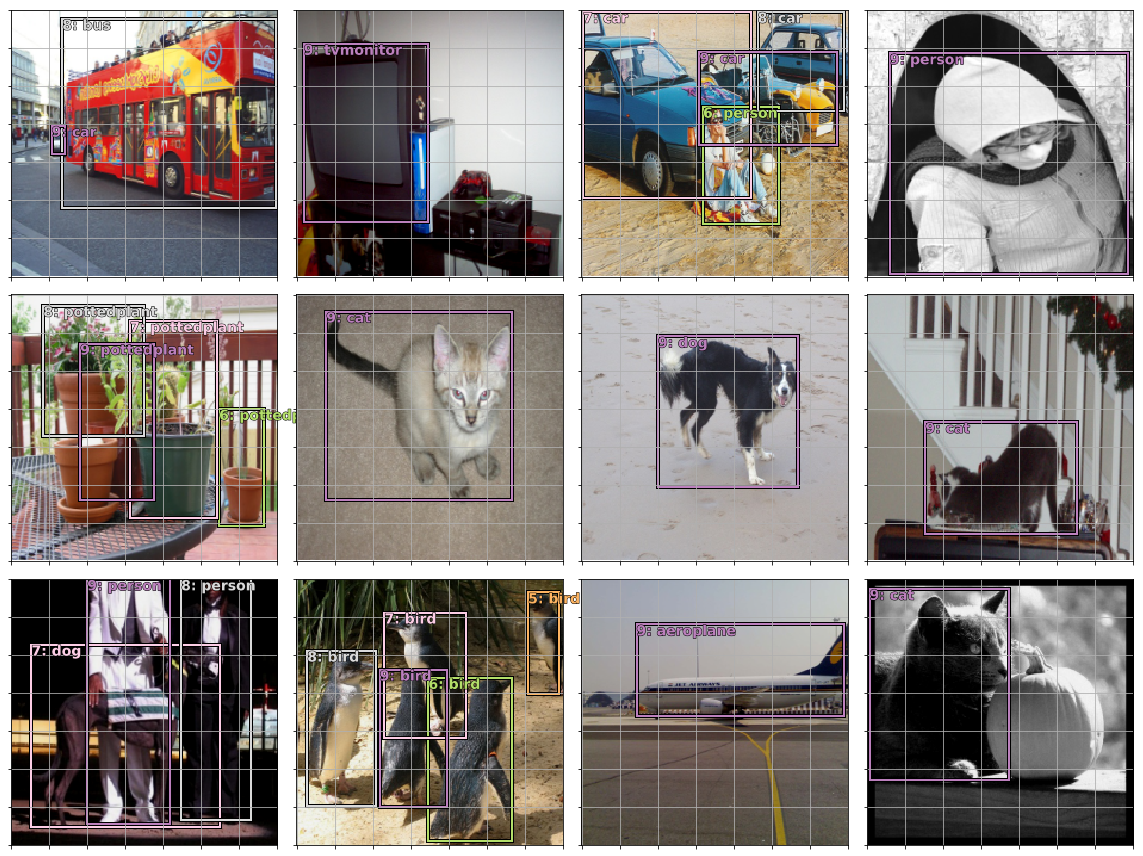

In [332]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i]) 
plt.tight_layout()

### Set up model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

In [333]:
anc_grid = 4
k = 1

anc_offset = 1 / (anc_grid * 2) #defining anchor offset based on grid size

In [334]:
anc_offset

0.125

In [335]:
anc_x = np.repeat(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid) #x-coordinate of anchor centre

In [336]:
anc_x 

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625, 0.625, 0.625, 0.625, 0.875, 0.875,
       0.875, 0.875])

In [337]:
anc_y = np.tile(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid) #y-coordinate of anchor centre

In [338]:
anc_y

array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375,
       0.625, 0.875])

In [339]:
np.stack([anc_x, anc_y], axis=1) #(x,y) for centre for every grid

array([[0.125, 0.125],
       [0.125, 0.375],
       [0.125, 0.625],
       [0.125, 0.875],
       [0.375, 0.125],
       [0.375, 0.375],
       [0.375, 0.625],
       [0.375, 0.875],
       [0.625, 0.125],
       [0.625, 0.375],
       [0.625, 0.625],
       [0.625, 0.875],
       [0.875, 0.125],
       [0.875, 0.375],
       [0.875, 0.625],
       [0.875, 0.875]])

In [340]:
anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k, 1)) #for every anchor we define 16 centres corresponding to each grid cell

In [341]:
#defining height and width of the anchor boxes
anc_sizes = np.array(
    [[1 / anc_grid, 1 / anc_grid] for i in range(anc_grid * anc_grid)])

In [342]:
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

In [343]:
np.concatenate([anc_ctrs, anc_sizes], axis=1)

array([[0.125, 0.125, 0.25 , 0.25 ],
       [0.125, 0.375, 0.25 , 0.25 ],
       [0.125, 0.625, 0.25 , 0.25 ],
       [0.125, 0.875, 0.25 , 0.25 ],
       [0.375, 0.125, 0.25 , 0.25 ],
       [0.375, 0.375, 0.25 , 0.25 ],
       [0.375, 0.625, 0.25 , 0.25 ],
       [0.375, 0.875, 0.25 , 0.25 ],
       [0.625, 0.125, 0.25 , 0.25 ],
       [0.625, 0.375, 0.25 , 0.25 ],
       [0.625, 0.625, 0.25 , 0.25 ],
       [0.625, 0.875, 0.25 , 0.25 ],
       [0.875, 0.125, 0.25 , 0.25 ],
       [0.875, 0.375, 0.25 , 0.25 ],
       [0.875, 0.625, 0.25 , 0.25 ],
       [0.875, 0.875, 0.25 , 0.25 ]])

In [344]:
#defining anchors (x,y,height,width)
anchors = V(
    np.concatenate([anc_ctrs, anc_sizes], axis=1),
    requires_grad=False).float()

Unsqueeze is useful and lets us insert the dimension without explicitly being aware of the other dimensions when writing the code.

In [345]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1) #inserting dimension at position 1

In [346]:
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

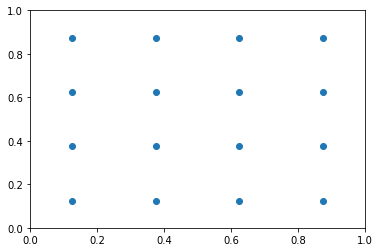

In [347]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [348]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [349]:
def hw2corners(ctr, hw):
    '''
    converting reference from centre to corner
    '''
    return torch.cat([ctr - hw / 2, ctr + hw / 2], dim=1)

In [350]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

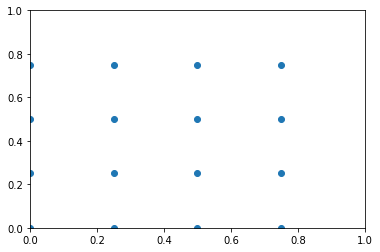

In [351]:
plt.scatter(anchor_cnr[:,0].data, anchor_cnr[:,1].data)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [352]:
n_clas = len(id2cat) + 1  #adding for background class
n_act = k * (4 + n_clas) #depth of prediction: for each of the k anchors you have 4 bbox prediction and n_clas prediction

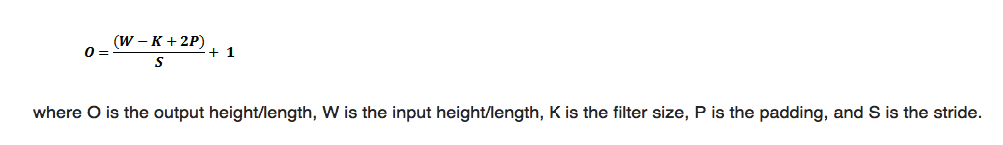

In [353]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout,kernel_size= 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))


def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf // k)

In [362]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat) + 1) * k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4 * k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)

    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

In [363]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(
            512, 256, stride=1)  #input: 7x7x512, output: 7x7x256
        #         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256, 256, stride=2)  #input:7x7x256 output is 4x4x256
        self.out = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        #         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [356]:
head_reg4 = SSD_Head(k, -3.)  #creating a custom head over the resnet34

In [357]:
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

In [358]:
learn = ConvLearner(md, models)

In [359]:
learn.summary #output from 7th layer of resnet is 7x7x512

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [360]:
learn.opt_fn = optim.Adam

In [361]:
k

1

### Train

In [279]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [280]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [281]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [282]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [283]:
x.size()

torch.Size([64, 3, 224, 224])

In [265]:
type(y)

list

In [266]:
for i,o in enumerate(y): y[i] = o.cpu()
learn.model.cpu()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [267]:
batch = learn.model(x)

RuntimeError: Input type (CUDAFloatTensor) and weight type (CPUFloatTensor) should be the same

In [260]:
anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [284]:
ssd_loss(batch, y, True)


 0.1947
 0.1168
 0.2652
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2885
 0.0888
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.9027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.1608
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3237
 0.2153
 0.2558
 0.2013
 0.2526
 0.0485
 0.0879
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3258
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2704
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.4538
 0.1897
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.1527
 0.1863
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3249
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0642
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2418
 0.2337
 0.2590
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  8.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3652
 0.1377
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.5146
  5.739

Variable containing:
 83.5720
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [285]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      97.522579  250645.12175



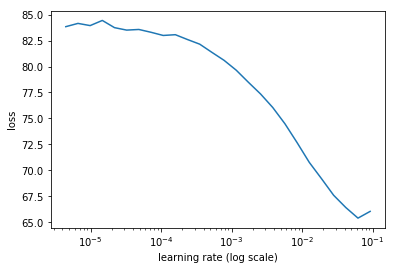

In [286]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [287]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      42.896872  32.726121 
    1      33.581234  27.995716                           
    2      29.264986  27.581019                           
    3      26.614044  26.299324                           
    4      24.398028  25.766703                           



[array([25.7667])]

In [288]:
learn.save('0')

In [289]:
learn.load('0')

### Testing

In [290]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)

In [291]:
learn.model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [292]:
batch = learn.model(x)

In [294]:
b_clas,b_bb = batch

In [295]:
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [296]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]

In [297]:
ima=md.val_ds.ds.denorm(to_np(x))[idx]

In [298]:
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [ ]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [ ]:
grid_sizes

In [ ]:
anchors

In [ ]:
a_ic = actn_to_bb(b_bboxi, anchors)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [ ]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps

In [ ]:
overlaps.max(1)

In [ ]:
overlaps.max(0)

In [ ]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

In [ ]:
gt_clas = clas[gt_idx]; gt_clas

In [ ]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx

In [ ]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

In [ ]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

## More anchors!

### Create anchors

In [ ]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

In [ ]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [ ]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [ ]:
anchors

In [ ]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [ ]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

### Model

In [ ]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [ ]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(V(x))

In [ ]:
batch[0].size(),batch[1].size()

In [ ]:
ssd_loss(batch, y, True)

In [ ]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [ ]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

In [ ]:
learn.save('tmp')

In [ ]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

In [ ]:
learn.save('prefocal')

In [ ]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
plt.tight_layout()

## Focal loss

In [ ]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [ ]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [ ]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y, True)

In [ ]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [ ]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

In [ ]:
learn.save('fl0')

In [ ]:
learn.load('fl0')

In [ ]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

In [ ]:
learn.save('drop4')

In [ ]:
learn.load('drop4')

In [ ]:
plot_results(0.75)

## NMS

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [ ]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [ ]:
def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

In [ ]:
for i in range(12): show_nmf(i)

## End